# Human Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Features Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists on importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

In [0]:
#@title Import Time Series Features Library
import warnings
warnings.filterwarnings('ignore')
!git clone https://github.com/TSFDlib/TSFEL.git >/dev/null 2>&1
!pip install --upgrade -q gspread >/dev/null 2>&1
!pip install gspread oauth2client >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install novainstrumentation >/dev/null 2>&1
!pip install pandas_profiling >/dev/null 2>&1

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If a TSFEL paste does not appear run Import Time Series Features library again.

---


#Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

To access this dataset click [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/) and dowload the zip "UCI_HAR_Dataset". Now, unzip the folder and upload to "Files" the txt under the following directories:

*   UCI HAR Dataset/train/Inertial Signals/ (all txt)
*   UCI HAR Dataset/test/Inertial Signals/  (all txt)
*   UCI HAR Dataset/train/y_train.txt
*   UCI HAR Dataset/test/y_test.txt
*   UCI HAR Dataset/activity_labels.txt





In [0]:
#@title Data Preparation
# Import libraries
import secrets
import pandas as pd 
import numpy as np
import TSFEL as tslib
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

# Load data
x_train_sig = np.loadtxt('total_acc_x_train.txt', dtype='float32')
x_test_sig = np.loadtxt('total_acc_x_test.txt', dtype='float32')
y_test = np.loadtxt('y_test.txt')
y_train = np.loadtxt('y_train.txt')
activity_labels = np.array(pd.read_csv('activity_labels.txt', header=None, delimiter=' '))[:,1]

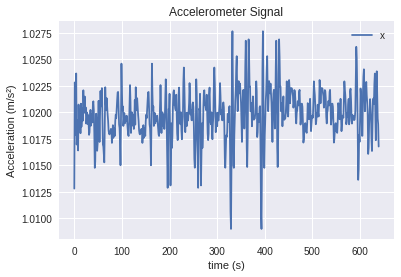

In [0]:
#@Signal Preview
%matplotlib inline
plt.figure()
plt.plot(np.concatenate(x_train_sig[0:5],axis=0))
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
plt.legend('x axis')
plt.show()

#Feature Extraction

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/15Db3m7if7xkZBqHDUXtFxrwIcBqKvIBU0XnV6aKa4SI/edit?ts=5bd1eca0#gid=0). Save a copy on your local drive and share it with featext@featext.iam.gserviceaccount.com.

Run the following code and change your google sheet file name to the name presented.

In [0]:
#@title Google Sheet name
googleSheet_name = 'Configuration Manager: ' + secrets.token_hex(8)
googleSheet_name

'Configuration Manager: 451c682a3c609490'

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

A feature report is saved in /utils.

In [0]:
#@title Feature Extraction

# Extract excel info
cfg_file = tslib.extract_sheet(googleSheet_name)

# Get features
X_train = tslib.extract_features(x_train_sig, 'x', cfg_file, segment=False)
X_test = tslib.extract_features(x_test_sig, 'x', cfg_file, segment=False)

*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [0]:
#@title Removal of highly correlated features

# Concatenation of entire data
features = pd.concat([X_train, X_test])
# Highly correlated features are removed
features = tslib.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

In [0]:
#@title Preview Features
st1 = pd.DataFrame(data=np.array(['c']*features.shape[1]).reshape(1,-1), columns = list(features.columns))
st2 = pd.DataFrame(data=np.array([' ']*features.shape[1]).reshape(1,-1), columns = list(features.columns))
feat = pd.concat([st1, st2], axis=0, ignore_index=True)
feat = pd.concat([feat, features], axis=0, ignore_index=True)
labels = np.concatenate([y_train, y_test])
disc_labels = []
for l in labels:
  if l == 1:
    disc_labels.append('WALKING')
  elif l == 2:
    disc_labels.append('WALKING_UPSTAIRS')
  elif l == 3:
    disc_labels.append('WALKING_DOWNSTAIRS')
  elif l == 4:
    disc_labels.append('SITTING')
  elif l == 5:
    disc_labels.append('STANDING')
  elif l == 6:
    disc_labels.append('LAYING')
disc_labels = pd.DataFrame(data=disc_labels, columns=['Activity'])
disc_labels = pd.concat([pd.DataFrame(data=['d','class'], columns=['Activity']), disc_labels], axis=0, ignore_index=True)
orange_input= pd.concat([feat, disc_labels], axis=1)
orange_input.to_csv('TSFEL/tsfel/orange_input.csv', sep=',', encoding='utf-8', index=False)
features

,tot_x_Autocorrelation,tot_x_Centroid,tot_x_Curve distance,tot_x_Fundamental frequency,tot_x_Interquartile range,tot_x_Kurtosis,tot_x_Linear regression,tot_x_Max,tot_x_Max power spectrum,tot_x_Maximum frequency,...,gyr_y_Spectral roll-on,gyr_y_Spectral skewness,gyr_y_Spectral slope,gyr_y_Spectral spread,gyr_y_Spectral variation,gyr_y_Standard Deviation,gyr_y_Sum absolute diff,gyr_y_Total energy,gyr_y_Variance,gyr_y_Zero crossing rate
0,132.990082,0.600000,-5.378850,7.142857,0.002154,1.252338,0.000040,1.024606,0.145345,42.857143,...,0.793651,1.166100,-0.006340,224.715515,0.954019,0.020845,0.457460,0.161060,0.000435,0.0
1,133.027573,0.600174,-11.461497,7.142857,0.002227,1.274470,0.000057,1.024606,0.168814,38.095238,...,0.793651,1.462590,-0.004609,137.163278,0.626770,0.010520,0.391671,0.063484,0.000111,0.0
2,133.153091,0.600440,-20.330274,6.349206,0.003097,1.796904,0.000430,1.027664,0.158406,35.714286,...,1.587302,1.345433,-0.004155,114.374097,0.438446,0.009299,0.470859,0.082206,0.000086,0.0
3,133.263214,0.600048,-17.354680,2.380952,0.002786,3.924806,0.000038,1.027664,0.072581,37.301587,...,0.793651,1.162669,-0.003604,149.936013,0.640139,0.008608,0.407493,0.053867,0.000074,0.0
4,133.238373,0.599864,-12.770025,6.349206,0.002506,0.980626,-0.000138,1.026194,0.138429,38.888889,...,0.793651,1.440191,-0.003701,114.317059,0.590173,0.007698,0.341638,0.040168,0.000059,0.0
5,133.218201,0.600062,-14.468570,2.380952,0.002937,0.231196,-0.000064,1.026194,0.225888,37.301587,...,0.793651,1.480815,-0.004048,131.542856,0.861172,0.009092,0.348774,0.040095,0.000083,0.0
6,133.336243,0.600031,-13.127302,4.761905,0.003302,-0.403270,0.000281,1.027167,0.270912,42.857143,...,0.793651,1.415019,-0.004570,125.524410,0.567879,0.010057,0.440991,0.043333,0.000101,0.0
7,133.331238,0.599679,-18.351105,7.142857,0.003470,-0.369774,-0.000419,1.027167,0.174296,38.095238,...,0.793651,1.342705,-0.004057,132.069401,0.549172,0.008881,0.420771,0.044693,0.000079,0.0
8,133.321686,0.599966,-15.176105,6.349206,0.002640,0.457663,0.000194,1.027036,0.115106,37.301587,...,0.793651,0.917256,-0.002760,162.350940,0.527651,0.006713,0.368507,0.025429,0.000045,0.0
9,133.487946,0.600263,-20.852336,5.555556,0.003564,0.501358,0.000183,1.028210,0.236294,36.507937,...,0.793651,1.050388,-0.005105,120.473642,0.709204,0.012376,0.599095,0.052113,0.000153,0.0


#Classification

In this example the classification is performed with a [Decision Tree](https://scikit-learn.org/stable/modules/tree.html) classifier.
  

In [0]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) *100
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

         1.0       0.72      0.86      0.78       496
         2.0       0.78      0.67      0.72       471
         3.0       0.81      0.75      0.78       420
         4.0       0.57      0.53      0.55       491
         5.0       0.59      0.62      0.61       532
         6.0       1.00      1.00      1.00       537

   micro avg       0.74      0.74      0.74      2947
   macro avg       0.74      0.74      0.74      2947
weighted avg       0.74      0.74      0.74      2947

Accuracy: 74.21106209704784%


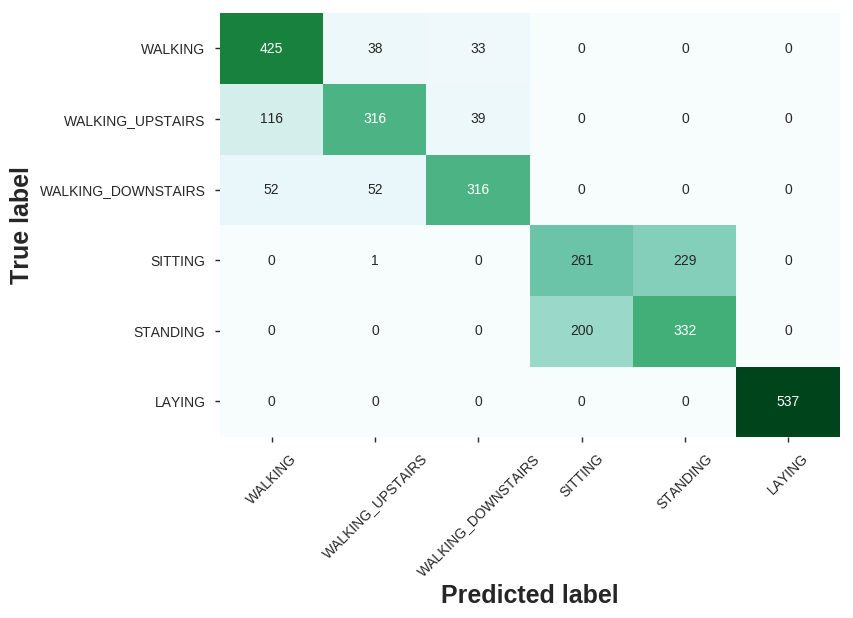

In [0]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)
plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.

# Improvements

In [0]:
#@title Add more signals

# Load data
y_train_sig = np.loadtxt('total_acc_y_train.txt', dtype='float32')
y_test_sig = np.loadtxt('total_acc_y_test.txt', dtype='float32')
z_train_sig = np.loadtxt('total_acc_z_train.txt', dtype='float32')
z_test_sig = np.loadtxt('total_acc_z_test.txt', dtype='float32')
import numba      


@numba.jit
def magnitude(all_sig):
  mag_train = []
  for i in range(len(all_sig[0])):
    mag_row= []
    for j in range(len(all_sig[0][i])):
        mag_row.append(np.sqrt(all_sig[0][i,j]**2 + all_sig[1][i,j]**2 + all_sig[2][i,j]**2))
    mag_train.append(mag_row)
  
  return np.array(mag_train)

## Data Preparation
@numba.jit
def extract_sig(dir, sig_name, mag=True):
  feat = pd.DataFrame()
  all_sig = []
  for idx_d, d in enumerate(dir):
    sig = np.loadtxt(d, dtype='float32')
    XMag_test = tslib.extract_features(sig, sig_name[idx_d], cfg_file, segment=False)
    feat = pd.concat([feat, XMag_test], axis=1)
    if mag:
      all_sig.append(sig)
      if idx_d == 2 or idx_d == 5 or idx_d == 8:
        _mag = magnitude(all_sig)
        feat_mag = tslib.extract_features(_mag, sig_name[idx_d+1], cfg_file, segment=False)
        feat = pd.concat([feat, feat_mag], axis=1)
        all_sig=[]
  return feat


dir = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt', 
       'body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt',
      'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
sig_name = ['tot_x', 'tot_y', 'tot_z','tot_mag', 'body_x', 'body_y', 'body_z', 'body_mag',
           'gyr_x', 'gyr_y', 'gyr_z', 'gyr_mag']
X_train = extract_sig(dir, sig_name, mag=True)

dir = ['total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt', 
       'body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt',
      'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
X_test = extract_sig(dir, sig_name, mag=True)

## Feature Selection
# Concatenation of entire data
names = [Xt.replace(" ", "_") for Xt in X_train.columns]
features = pd.concat([X_train, X_test], names=names)
# Highly correlated features are removed
#features = tslib.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

# Classification
classifier = DecisionTreeClassifier()
# Train the classifier
classifier.fit(X_train, y_train.ravel())
# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict)*100
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Fe

In [0]:
#@title Try more classifiers

import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

labels = np.concatenate([y_train, y_test])
# Finds best supervised learning classifier
classifier = tslib.find_best_slclassifier(features, labels, X_train, X_test, y_train, y_test)

Nearest Neighbors
Accuracy: 0.786 (+/- 0.051)
Accuracy: 78.79199185612488%
-----------------------------------------
Decision Tree
Accuracy: 0.853 (+/- 0.066)
Accuracy: 84.45877163216831%
-----------------------------------------
Random Forest
Accuracy: 0.792 (+/- 0.074)
Accuracy: 82.18527315914488%
-----------------------------------------
AdaBoost
Accuracy: 0.539 (+/- 0.008)
Accuracy: 53.10485239226331%
-----------------------------------------
Naive Bayes
Accuracy: 0.858 (+/- 0.052)
Accuracy: 85.81608415337631%
-----------------------------------------
QDA
Accuracy: 0.853 (+/- 0.075)
Accuracy: 89.71835765184933%
-----------------------------------------
******** Best Classifier: QDA ********


In [0]:
#@title Feature Selection
# Feature Selection
FS_X_train, FS_X_test, FS_lab_description = tslib.FSE(X_train, X_test, y_train, y_test, list(X_train.columns), classifier)
    
# Train the classifier
classifier.fit(FS_X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(FS_X_test)

# Get the classification accuracy
accuracy = accuracy_score(y_test, y_test_predict)*100
scores = cross_val_score(classifier, np.concatenate([FS_X_train,FS_X_test]), labels, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print("Accuracy: " + str(accuracy) + '%')

*** Feature selection started ***
FINAL Features: ['tot_x_Max', 'body_z_Zero crossing rate', 'tot_mag_Median', 'tot_z_Spectral centroid', 'gyr_x_Spectral variation', 'body_z_Spectral decrease', 'tot_mag_Median frequency', 'body_z_Mean absolute diff', 'tot_z_Median absolute diff', 'body_z_Spectral kurtosis', 'tot_z_Spectral spread', 'gyr_x_Max power spectrum', 'body_mag_Spectral variation', 'body_x_Zero crossing rate', 'body_z_Skewness', 'tot_y_Spectral roll-on', 'tot_mag_Minimum peaks', 'body_z_Spectral skewness', 'tot_x_Fundamental frequency', 'tot_z_Median frequency', 'tot_x_Spectral maximum peaks', 'body_x_Spectral spread', 'body_y_Spectral centroid', 'body_z_Spectral variation']
Number of features 24
Acc:  [0.6596538853070919, 0.7729894808279606, 0.832032575500509, 0.8696979979640312, 0.8907363420427553, 0.8998982015609094, 0.9127926705123854, 0.9250084832032576, 0.9317950458092976, 0.9375636240244316, 0.9423142178486597, 0.9480827960637936, 0.9511367492365117, 0.9548693586698337, 

# Orange

Dowload the file TSFEL/tsfel/orange_input.csv and open Orange.